<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
#### *Data Science Unit 4 Sprint 1 Assignment 1*

## *Tobias Reaper, DS8*

---
---

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques:

- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbers from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

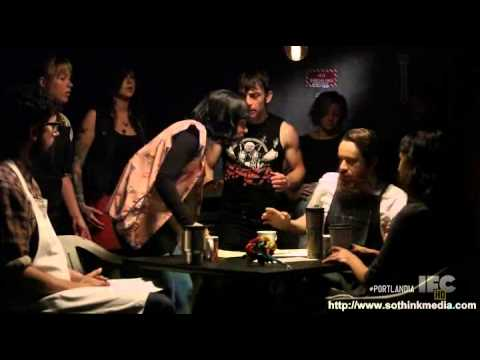

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

---
---

## First Looks and Wrangling

In [2]:
import pandas as pd

# Relative path to the dataset
datapath = "data/yelp_coffeeshop_review_data.csv"

# Load data
df1 = pd.read_csv(datapath)

In [3]:
# Set pandas to display more text
pd.options.display.max_colwidth = 100

In [4]:
df1.shape

(7616, 3)

In [5]:
# First looks at the head
df1.head(8)

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its o...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Ins...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots I loved the eclectic and homey plush decor and who...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice seating However... Just about everything is over...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within the Northcross mall shopping center facing east to...,4.0 star rating
5,The Factory - Cafe With a Soul,"11/20/2016 1 check-in Very cute cafe! I think from the moment I stepped in, there really wasn't...",4.0 star rating
6,The Factory - Cafe With a Soul,"10/27/2016 2 check-ins Listed in ""Nuptial Coffee Bliss!"", Anderson Lane is the new Black Oh hey...",4.0 star rating
7,The Factory - Cafe With a Soul,11/2/2016 2 check-ins Love this place! 5 stars for cleanliness 5 stars for fun ambiance/ open ...,5.0 star rating


In [6]:
# Also check out the tail to get a better feel for the data
df1.tail(8)

,coffee_shop_name,full_review_text,star_rating
7608,The Steeping Room,9/20/2015 I come here when I visit my friend in Austin for a fun place with lots of yummy optio...,4.0 star rating
7609,The Steeping Room,"12/7/2014 1 check-in After noticing many friends have come here and really enjoyed it, I decide...",4.0 star rating
7610,The Steeping Room,3/1/2016 Great food! I haven't had a meal I did not enjoy here. It's very clean and great for p...,5.0 star rating
7611,The Steeping Room,2/19/2015 I actually step into this restaurant by chance and now is one of my favorites in Aust...,4.0 star rating
7612,The Steeping Room,"1/21/2016 Ok, The Steeping Room IS awesome. How do they have so many great menu items. Of cours...",5.0 star rating
7613,The Steeping Room,"4/30/2015 Loved coming here for tea, and the atmosphere was pretty and fresh. I ordered the str...",4.0 star rating
7614,The Steeping Room,8/2/2015 The food is just average. The booths didn't feel very clean. The waitstaff was friendl...,3.0 star rating
7615,The Steeping Room,5/23/2015 I finally stopped in for lunch with my colleague and I'm so glad we did. I had a deli...,4.0 star rating


---

## Data Wrangles

- [x] Date removed or as new column
- [x] Make all text lowercase
- [x] Star rating as number
- [x] Extract check-in count to new column

<h3 id="splitdate">Split date into new column</h3>

In [7]:
# ====== Separate out the date into new column ====== #
# To do this, I can simple split the cell on whitespace, and only access the first item
df2 = df1.copy()
df2["date"] = df2["full_review_text"].str.split().str[0]
df2.head()
# The issue with this method is I'd have to then get the rest of the review, sans-date

,coffee_shop_name,full_review_text,star_rating,date
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its o...,5.0 star rating,11/25/2016
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Ins...",4.0 star rating,12/2/2016
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots I loved the eclectic and homey plush decor and who...,4.0 star rating,11/30/2016
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice seating However... Just about everything is over...,2.0 star rating,11/25/2016
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within the Northcross mall shopping center facing east to...,4.0 star rating,12/3/2016


In [8]:
# ====== Split the date into new column ====== #
# A better method would be to expand the str.split, limiting the expansion to 1
df2 = df1.copy()  # Create a copy of the dataframe

# Create new columns for the result of the 1-way split
df2[["date", "review_text"]] = df2["full_review_text"].str.split(expand=True, n=1)

# Drop the original column
df2 = df2.drop(columns=["full_review_text"])

df2.head()  # Look at the results

,coffee_shop_name,star_rating,date,review_text
0,The Factory - Cafe With a Soul,5.0 star rating,11/25/2016,"1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, an..."
1,The Factory - Cafe With a Soul,4.0 star rating,12/2/2016,"Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Instagram-wort..."
2,The Factory - Cafe With a Soul,4.0 star rating,11/30/2016,1 check-in Listed in Brunch Spots I loved the eclectic and homey plush decor and who doesn't wan...
3,The Factory - Cafe With a Soul,2.0 star rating,11/25/2016,Very cool decor! Good drinks Nice seating However... Just about everything is overpriced. $1.5...
4,The Factory - Cafe With a Soul,4.0 star rating,12/3/2016,1 check-in They are located within the Northcross mall shopping center facing east toward Burnet...


In [16]:
# More detailed view of the date column
# First convert to datetime format
df2["date"] = pd.to_datetime(df2["date"], infer_datetime_format=True)
df2["date"].describe()

count                    7616
unique                   1592
top       2016-10-09 00:00:00
freq                       31
first     2006-11-11 00:00:00
last      2016-12-05 00:00:00
Name: date, dtype: object

<h3 id="review-lowercase">Make all review text lowercase</h3>

In [13]:
# ====== Use str.lower to make lowercase ====== #

# Make review_text lowercase
df2["review_text"] = df2["review_text"].str.lower()

# Look at the results
df2.head()

,coffee_shop_name,star_rating,date,review_text
0,The Factory - Cafe With a Soul,5.0 star rating,11/25/2016,"1 check-in love love loved the atmosphere! every corner of the coffee shop had its own style, an..."
1,The Factory - Cafe With a Soul,4.0 star rating,12/2/2016,"listed in date night: austin, ambiance in austin beautiful!!!! love the ambiance! instagram-wort..."
2,The Factory - Cafe With a Soul,4.0 star rating,11/30/2016,1 check-in listed in brunch spots i loved the eclectic and homey plush decor and who doesn't wan...
3,The Factory - Cafe With a Soul,2.0 star rating,11/25/2016,very cool decor! good drinks nice seating however... just about everything is overpriced. $1.5...
4,The Factory - Cafe With a Soul,4.0 star rating,12/3/2016,1 check-in they are located within the northcross mall shopping center facing east toward burnet...


<h3 id="rating-to-float">star_rating as number</h3>

In [18]:
# ====== Strip letters from star_rating, convert to float ====== #
# This can be done a similar way to the first method of extracting the date I used above
df2["star_rating"] = df2["star_rating"].str.split().str[0].astype(float)

df2.head()

,coffee_shop_name,star_rating,date,review_text
0,The Factory - Cafe With a Soul,5.0,2016-11-25,"1 check-in love love loved the atmosphere! every corner of the coffee shop had its own style, an..."
1,The Factory - Cafe With a Soul,4.0,2016-12-02,"listed in date night: austin, ambiance in austin beautiful!!!! love the ambiance! instagram-wort..."
2,The Factory - Cafe With a Soul,4.0,2016-11-30,1 check-in listed in brunch spots i loved the eclectic and homey plush decor and who doesn't wan...
3,The Factory - Cafe With a Soul,2.0,2016-11-25,very cool decor! good drinks nice seating however... just about everything is overpriced. $1.5...
4,The Factory - Cafe With a Soul,4.0,2016-12-03,1 check-in they are located within the northcross mall shopping center facing east toward burnet...


In [19]:
# Look at star_rating in a little more detail
df2["star_rating"].describe()

count    7616.000000
mean        4.169118
std         1.065311
min         1.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: star_rating, dtype: float64

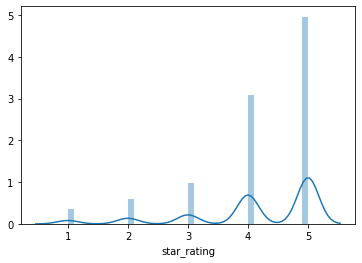

In [21]:
# star_rating as a distplot
import seaborn as sns
sns.distplot(df2["star_rating"]);

<h3 id="extract-checkin">Extract check-in count to new column</h3>

In [41]:
# ====== Use str.extract with regex to extract check-ins ====== #
# Copy the dataframe first, for posterity (in case I want to go back)
df3 = df2.copy()

# Use regex to extract the checkins from the review_text column
# the first group 'check_ins' is optional, so if it does not exist, it will return entire text
df3[["check_ins", "review_text"]] = df3["review_text"].str.extract(r"(?P<check_ins>\d check-in)?(?P<review>.*)")

df3.head()

,coffee_shop_name,star_rating,date,review_text,check_ins
0,The Factory - Cafe With a Soul,5.0,2016-11-25,"love love loved the atmosphere! every corner of the coffee shop had its own style, and there we...",1 check-in
1,The Factory - Cafe With a Soul,4.0,2016-12-02,"listed in date night: austin, ambiance in austin beautiful!!!! love the ambiance! instagram-wort...",NaN
2,The Factory - Cafe With a Soul,4.0,2016-11-30,listed in brunch spots i loved the eclectic and homey plush decor and who doesn't want to swing...,1 check-in
3,The Factory - Cafe With a Soul,2.0,2016-11-25,very cool decor! good drinks nice seating however... just about everything is overpriced. $1.5...,NaN
4,The Factory - Cafe With a Soul,4.0,2016-12-03,they are located within the northcross mall shopping center facing east toward burnet rd with p...,1 check-in


In [37]:
df3.isnull().sum()

coffee_shop_name       0
star_rating            0
date                   0
review_text            0
check_ins           4889
num_checkins        4889
dtype: int64

In [42]:
# Clean up the check_ins column
df3["check_ins"] = df3["check_ins"].str.split().str[0]

# Fill the NaN values with 0
df3 = df3.fillna(0)

# Convert to integer
df3["check_ins"] = df3["check_ins"].astype(int)

# Look at the results
df3.head()

,coffee_shop_name,star_rating,date,review_text,check_ins
0,The Factory - Cafe With a Soul,5.0,2016-11-25,"love love loved the atmosphere! every corner of the coffee shop had its own style, and there we...",1
1,The Factory - Cafe With a Soul,4.0,2016-12-02,"listed in date night: austin, ambiance in austin beautiful!!!! love the ambiance! instagram-wort...",0
2,The Factory - Cafe With a Soul,4.0,2016-11-30,listed in brunch spots i loved the eclectic and homey plush decor and who doesn't want to swing...,1
3,The Factory - Cafe With a Soul,2.0,2016-11-25,very cool decor! good drinks nice seating however... just about everything is overpriced. $1.5...,0
4,The Factory - Cafe With a Soul,4.0,2016-12-03,they are located within the northcross mall shopping center facing east toward burnet rd with p...,1


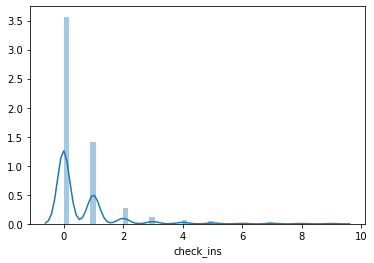

In [44]:
# Look at distplot of check_ins
sns.distplot(df3["check_ins"]);

In [45]:
# Look at summary of check_ins
df3["check_ins"].describe()

count    7616.000000
mean        0.611213
std         1.213938
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         9.000000
Name: check_ins, dtype: float64

---
---

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [46]:
# ====== Imports ======
from collections import Counter

# More plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import spacy
from spacy.tokenizer import Tokenizer

In [47]:
def count(docs):
    """Returns a dataframe of word counts from a corpus of documents."""

    # Instantiate collections.Counter objects
    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    # Update the Counters with doc tokens
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    # Create dataframe from word_counts
    temp = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # Rank the words according to count
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    
    # Calculate percentage / normalize the counts
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    # Cumulative percentage
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    # Add the appears_in and normalize, same as with count
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')  # Merge appears_in into original df
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

## Token analysis using spaCy

In [48]:
# Instantiate large spacy language model
nlp = spacy.load("en_core_web_lg")

# Instantiate and configure the tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [49]:
# ====== Posterify! ====== #
df4 = df3.copy()

In [51]:
# Look at the head again to get re-oriented
print(df4.shape)
df4.head(2)

(7616, 5)


,coffee_shop_name,star_rating,date,review_text,check_ins
0,The Factory - Cafe With a Soul,5.0,2016-11-25,"love love loved the atmosphere! every corner of the coffee shop had its own style, and there we...",1
1,The Factory - Cafe With a Soul,4.0,2016-12-02,"listed in date night: austin, ambiance in austin beautiful!!!! love the ambiance! instagram-wort...",0


#### Tokenization, Part 1

In [52]:
# ====== Make them tokens using a tokenizer pipe ====== #
tokens = []

for doc in tokenizer.pipe(df4["review_text"], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

df4["tokens"] = tokens

In [53]:
# Check out some results
df4["tokens"].head()

0    [ , love, love, loved, the, atmosphere!, every, corner, of, the, coffee, shop, had, its, own, st...
1    [listed, in, date, night:, austin,, ambiance, in, austin, beautiful!!!!, love, the, ambiance!, i...
2    [ , listed, in, brunch, spots, i, loved, the, eclectic, and, homey, plush, decor, and, who, does...
3    [very, cool, decor!, good, drinks, nice, seating,  , however...,  , just, about, everything, is,...
4    [ , they, are, located, within, the, northcross, mall, shopping, center, facing, east, toward, b...
Name: tokens, dtype: object

It looks like I should've run a `str.strip` on the text columns prior to tokenization.

I'll run the tokenization again, after stripping the whitespace.

In [54]:
# ====== Strip leading / following whitespace ====== #
df4["review_text"] = df4["review_text"].str.strip()

df4["review_text"].head()

0    love love loved the atmosphere! every corner of the coffee shop had its own style, and there wer...
1    listed in date night: austin, ambiance in austin beautiful!!!! love the ambiance! instagram-wort...
2    listed in brunch spots i loved the eclectic and homey plush decor and who doesn't want to swing ...
3    very cool decor! good drinks nice seating  however...  just about everything is overpriced. $1.5...
4    they are located within the northcross mall shopping center facing east toward burnet rd with pl...
Name: review_text, dtype: object

#### Tokenization, Part 2

That looks better. Now converting to tokens again using the same code as above.

In [55]:
# ====== Make them tokens with a tokenizer pipe, pt II ====== #
tokens = []

for doc in tokenizer.pipe(df4["review_text"], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

df4["tokens"] = tokens  # This time replace the previous column
df4["tokens"].head()  # Confirm it worked as expected

0    [love, love, loved, the, atmosphere!, every, corner, of, the, coffee, shop, had, its, own, style...
1    [listed, in, date, night:, austin,, ambiance, in, austin, beautiful!!!!, love, the, ambiance!, i...
2    [listed, in, brunch, spots, i, loved, the, eclectic, and, homey, plush, decor, and, who, doesn't...
3    [very, cool, decor!, good, drinks, nice, seating,  , however...,  , just, about, everything, is,...
4    [they, are, located, within, the, northcross, mall, shopping, center, facing, east, toward, burn...
Name: tokens, dtype: object

#### Word count analysis

Time to utilize that function that was defined above to generate a word-count dataframe from the tokens column.

In [56]:
# Use the count function and scope the results
df4_wc = count(df4["tokens"])
df4_wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
49,the,6847,34649,1.0,0.043904,0.043904,0.899028
46,and,6853,26442,2.0,0.033505,0.077409,0.899816
67,a,6240,22657,3.0,0.028709,0.106118,0.819328
17,i,5511,19990,4.0,0.025330,0.131448,0.723608
71,to,5638,17008,5.0,0.021551,0.152999,0.740284


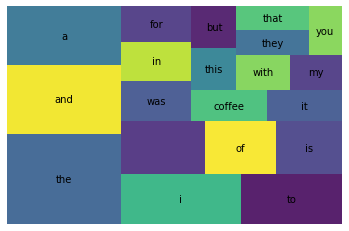

In [58]:
# === Visualize these tokens using squarify === #
# Take slice of top 20 words
df4_wc_top20 = df4_wc[df4_wc["rank"] <= 20]

# Plot with a word cloud
squarify.plot(sizes=df4_wc_top20["pct_total"], label=df4_wc_top20["word"], alpha=0.9)
plt.axis("off")
plt.show()

---

## Stop Words

Almost all of the top 20 words are stop words. Indeed, the only one that could be considered *not* a stop word is "coffee".

This section aims to take care of that using the spaCy defaults along with any additional stop words specific to this analysis.

In [ ]:
# ====== spaCy's default stop words ====== #
# nlp.Defaults.stop_words

#### Tokenization, Part 3

> *This time, without stop words!*

In [ ]:
# ====== Make them tokens with a tokenizer pipe, pt III ====== #
tokens = []

# This time, do not include stop words in the spacy default set
for doc in tokenizer.pipe(df4["review_text"], batch_size=500):
    
    doc_tokens = []  # Empty list to hold tokens for each doc
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    
    tokens.append(doc_tokens)

df4["tokens"] = tokens  # This time replace the previous column
df4["tokens"].head()  # Confirm it worked as expected

### View counts by rating

TODO: add this

---
---

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

